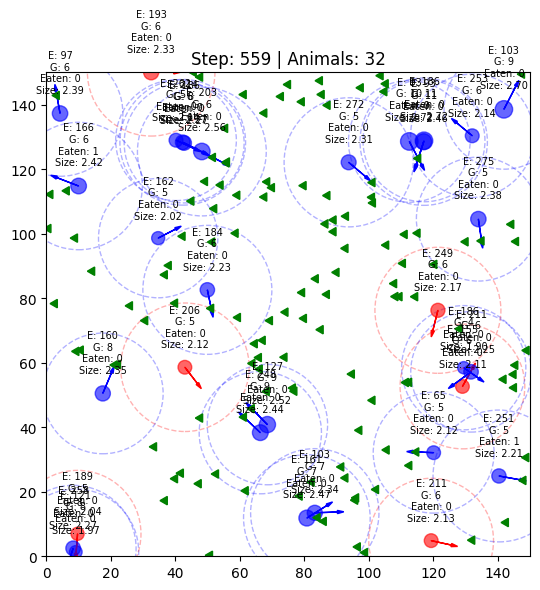

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from IPython.display import clear_output
import time

# Environment settings
FIELD_SIZE = 150
MAX_FOOD_ITEMS = 200  # Maximum number of food items
FOOD_RESPAWN_INTERVAL = 50  # Number of steps after which food respawns
FOOD_ENERGY_VALUE = 10
SMALL_VARIATION = 0.2
LARGE_VARIATION = 0.5

# Utility function to calculate distance between two positions
def distance(pos1, pos2):
    return np.linalg.norm(pos1 - pos2)

class Food:
    def __init__(self, position):
        self.position = np.array(position)

class Animal:
    def __init__(self, position, size=2, speed=1, energy=100, max_energy=150, radius_of_view=20, direction_change_interval=10, color='blue', generation=1):
        self.position = np.array(position, dtype='float')
        self.size = size
        self.speed = speed
        self.energy = energy
        self.max_energy = max_energy  # Maximum energy the animal can have
        self.radius_of_view = radius_of_view
        self.direction_change_interval = direction_change_interval
        self.steps_in_current_direction = 0
        self.current_direction = None  # Will be set when needed
        self.color = color
        self.generation = generation
        self.eaten_count = 0  # Initialize eaten animals counter

    def move(self, food_items):
        """Move the animal towards the closest food within its radius of view, or move randomly if no food is nearby."""
        closest_food = self.get_closest_food(food_items)

        if closest_food:
            self.move_towards(closest_food.position)
        else:
            self.random_move()

        # Handle boundary reflection after moving
        self.handle_boundary()

        self.energy -= 0.5  # Energy decreases over time

    def move_towards(self, target_position):
        """Move the animal towards a specific position."""
        direction = target_position - self.position
        norm = np.linalg.norm(direction)
        if norm == 0:
            return  # Already at the target
        direction /= norm  # Normalize direction vector
        self.current_direction = direction  # Store the direction for potential reflection
        self.position += self.current_direction * self.speed
        # No need to reset steps_in_current_direction here

    def random_move(self):
        """Move in a random direction for a set number of steps."""
        if self.steps_in_current_direction == 0 or self.current_direction is None:
            angle = np.random.uniform(0, 2 * np.pi)
            self.current_direction = np.array([np.cos(angle), np.sin(angle)])
            self.steps_in_current_direction = self.direction_change_interval

        self.position += self.current_direction * self.speed
        self.steps_in_current_direction -= 1

    def get_closest_food(self, food_items):
        """Find the closest food within the animal's radius of view."""
        if not food_items:
            return None

        food_positions = np.array([food.position for food in food_items])
        distances = np.linalg.norm(food_positions - self.position, axis=1)
        within_view = distances <= self.radius_of_view

        if np.any(within_view):
            closest_food_idx = np.argmin(distances[within_view])
            return food_items[np.where(within_view)[0][closest_food_idx]]

        return None

    def consume_food(self):
        """Increase energy when the animal consumes food."""
        self.energy += FOOD_ENERGY_VALUE
        if self.energy >= self.max_energy:
            return True  # Indicate that the animal should reproduce
        return False

    def is_alive(self):
        """Check if the animal is still alive (has energy greater than 0)."""
        return self.energy > 0

    def handle_boundary(self):
        """Handle reflection when the animal reaches the boundary."""
        for i in [0, 1]:  # 0 for x-axis, 1 for y-axis
            if self.position[i] < 0:
                self.position[i] = 0
                if self.current_direction is not None:
                    self.current_direction[i] *= -1  # Reverse direction on the axis
            elif self.position[i] > FIELD_SIZE:
                self.position[i] = FIELD_SIZE
                if self.current_direction is not None:
                    self.current_direction[i] *= -1  # Reverse direction on the axis

def produce_descendants(animal):
    """Produce two descendants at the same location as the parent with slight variations."""
    for _ in range(2):
        descendant = Animal(
            position=animal.position.copy(),
            size=max(1.5, animal.size + np.random.uniform(-SMALL_VARIATION, SMALL_VARIATION)),
            speed=max(0.5, animal.speed + np.random.uniform(-SMALL_VARIATION, SMALL_VARIATION)),
            energy=animal.energy / 2,  # Split energy between parent and descendants
            max_energy=animal.max_energy,
            radius_of_view=max(3, animal.radius_of_view + np.random.uniform(-LARGE_VARIATION, LARGE_VARIATION)),
            direction_change_interval=max(3, animal.direction_change_interval + np.random.uniform(-LARGE_VARIATION, LARGE_VARIATION)),
            color=animal.color,
            generation=animal.generation + 1
        )
        # Initialize eaten_count for the descendant
        descendant.eaten_count = 0
        animal.energy /= 2  # Deduct energy for reproduction
        yield descendant

def handle_food_consumption(animal, food_items):
    """Handle food consumption for an individual animal by consuming the closest food."""
    closest_food = animal.get_closest_food(food_items)
    if closest_food and distance(animal.position, closest_food.position) < animal.size:
        animal.consume_food()
        food_items.remove(closest_food)
        # Indicate that the animal should reproduce if energy threshold is reached
        if animal.energy >= animal.max_energy:
            return True
    return False

def respawn_food(food_items):
    """Respawn food to ensure the total number of food items is always equal to MAX_FOOD_ITEMS."""
    num_missing_food = MAX_FOOD_ITEMS - len(food_items)
    for _ in range(num_missing_food):
        new_food_pos = np.random.uniform(0, FIELD_SIZE, size=2)
        food_items.append(Food(position=new_food_pos))
    return food_items

def handle_animal_eating(animals):
    """
    Handle interactions where larger animals eat smaller ones.
    If two animals are touching and one is at least 1 unit larger, the larger eats the smaller.
    """
    eaten_animals = set()
    # Shuffle the list to randomize the order of interactions
    np.random.shuffle(animals)
    for i in range(len(animals)):
        if animals[i] in eaten_animals:
            continue
        for j in range(len(animals)):
            if i == j or animals[j] in eaten_animals:
                continue
            dist = distance(animals[i].position, animals[j].position)
            if dist < (animals[i].size + animals[j].size):
                if animals[i].size > animals[j].size + SMALL_VARIATION * 2:
                    # animals[i] eats animals[j]
                    animals[i].energy += animals[j].energy
                    animals[i].eaten_count += 1
                    eaten_animals.add(animals[j])
                elif animals[j].size > animals[i].size + SMALL_VARIATION * 2:
                    # animals[j] eats animals[i]
                    animals[j].energy += animals[i].energy
                    animals[j].eaten_count += 1
                    eaten_animals.add(animals[i])
    # Remove eaten animals from the list
    animals = [animal for animal in animals if animal not in eaten_animals]
    return animals

def visualize(animals, food_items, step):
    """Visualize the animals and food on the field."""
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw the animals
    for animal in animals:
        # Animal body
        circle = Circle(animal.position, animal.size, color=animal.color, alpha=0.6)
        ax.add_patch(circle)

        # Radius of view
        view_circle = Circle(animal.position, animal.radius_of_view, color=animal.color, fill=False, linestyle='--', alpha=0.3)
        ax.add_patch(view_circle)

        # Movement direction (if moving randomly or towards food)
        if animal.current_direction is not None:
            arrow_scale = animal.size * 3
            ax.arrow(
                animal.position[0],
                animal.position[1],
                animal.current_direction[0] * arrow_scale,
                animal.current_direction[1] * arrow_scale,
                head_width=1, head_length=2, fc=animal.color, ec=animal.color
            )

        # Display energy, generation, and eaten count
        ax.text(
            animal.position[0],
            animal.position[1] + animal.size + 4,  # Adjusted position for better visibility
            f"E: {int(animal.energy)}\n"
            f"G: {animal.generation}\n"
            f"Eaten: {animal.eaten_count}\n"
            f"Size: {animal.size:.2f}",
            color='black',
            fontsize=7,
            ha='center'
        )

    # Draw the food items
    for food in food_items:
        triangle = RegularPolygon(food.position, numVertices=3, radius=1.5, orientation=np.pi / 2, color='green')
        ax.add_patch(triangle)

    # Set field limits and aspect ratio
    ax.set_xlim(0, FIELD_SIZE)
    ax.set_ylim(0, FIELD_SIZE)
    ax.set_aspect('equal', 'box')
    ax.set_title(f"Step: {step} | Animals: {len(animals)}")
    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Close the figure to free memory

def simulate(animals, food_items, steps=1000):
    """Simulate the behavior of animals and food over a number of steps."""
    steps_since_last_respawn = 0

    for step in range(1, steps + 1):
        new_animals = []
        animals_to_remove = []
        
        # Shuffle animals to randomize consumption order
        np.random.shuffle(animals)

        for animal in animals:
            if animal.is_alive():
                animal.move(food_items)
                
                # Handle food consumption
                should_reproduce = handle_food_consumption(animal, food_items)
                
                # Handle reproduction
                if should_reproduce:
                    descendants = list(produce_descendants(animal))
                    new_animals.extend(descendants)
                    animals_to_remove.append(animal)

        # Remove animals that have reproduced
        animals = [animal for animal in animals if animal not in animals_to_remove and animal.is_alive()]
        # Add new descendants
        animals.extend(new_animals)
        
        if not animals:
            print(f"All animals have run out of energy by step {step}.")
            break

        # Handle animal eating interactions
        animals = handle_animal_eating(animals)

        if not animals:
            print(f"All animals have been eaten by step {step}.")
            break

        # Respawn food after a set interval
        steps_since_last_respawn += 1
        if steps_since_last_respawn >= FOOD_RESPAWN_INTERVAL:
            food_items = respawn_food(food_items)
            steps_since_last_respawn = 0

        # Visualize the current state
        visualize(animals, food_items, step)
        time.sleep(0.05)  # Reduced pause for faster simulation
        clear_output(wait=True)

def initialize_simulation():
    """Initialize animals and food for the simulation."""
    # Initialize animals
    animal1 = Animal(
        position=[FIELD_SIZE / 4, FIELD_SIZE / 4],
        size=2,
        speed=2,
        energy=100,
        max_energy=300,
        radius_of_view=20,
        direction_change_interval=10,
        color='blue'
    )
    animal2 = Animal(
        position=[3 * FIELD_SIZE / 4, 3 * FIELD_SIZE / 4],
        size=2,
        speed=2,
        energy=100,
        max_energy=300,
        radius_of_view=20,
        direction_change_interval=10,
        color='red'
    )
    animals = [animal1, animal2]

    # Generate initial random food positions
    food_items = [Food(position=np.random.uniform(0, FIELD_SIZE, size=2)) for _ in range(MAX_FOOD_ITEMS)]

    return animals, food_items

# Run the simulation
animals, food_items = initialize_simulation()
simulate(animals, food_items, steps=10000)


